In [12]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from unet import unet_model
import random
from pathlib import Path
import logging
LOGGER = logging.getLogger()

from skimage.morphology import binary_erosion
from skimage.morphology import skeletonize

from skimage.morphology import label
from skimage.measure import regionprops
from skimage.color import label2rgb

In [8]:
image_directory = 'dl_data/training/'
mask_directory = 'dl_data/ground_truth/'
SIZE = 512
image_dataset = []
mask_dataset = []

images = os.listdir(image_directory)
images = sorted(images)
print(images)
for i, image_name in enumerate(images):
    if (image_name.split('.')[-1] == 'png'):
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image = np.array(image)
        image_flip_y = cv2.flip(image, 0)
        image_flip_x = cv2.flip(image, 1)
        image_flip_xy = cv2.flip(image_flip_y, 1)
        for im in (image, image_flip_y, image_flip_x, image_flip_xy):
            image_dataset.append(im)
            image_dataset.append(cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE))
            image_dataset.append(cv2.rotate(im, cv2.ROTATE_180))
            image_dataset.append(cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE))

masks = os.listdir(mask_directory)
masks = sorted(masks)
print(masks)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory+image_name, 0)
        # image = Image.fromarray(image)
        # image = np.array(image).astype(bool)
        # image = skeletonize(image)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image = np.array(image)
        image_flip_y = cv2.flip(image, 0)
        image_flip_x = cv2.flip(image, 1)
        image_flip_xy = cv2.flip(image_flip_y, 1)
        for im in (image, image_flip_y, image_flip_x, image_flip_xy):
            mask_dataset.append(np.array(image).astype(bool))
            mask_dataset.append(cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE).astype(bool))
            mask_dataset.append(cv2.rotate(im, cv2.ROTATE_180).astype(bool))
            mask_dataset.append(cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE).astype(bool))

# for i, image_name in enumerate(masks):
#     if (image_name.split('.')[1] == 'png'):
#         image = cv2.imread(mask_directory+image_name, 0)
#         image = Image.fromarray(image)
#         image = image.resize((SIZE, SIZE))
#         mask_dataset.append(np.array(image))


['task-20-20230207_Me4_NPs_perov_1um.0_00009.png', 'task-21-20230207_Me4_NPs_perov_5um.0_00006.png', 'task-22-20230207_Me4_NPs_perov_10um.0_00007.png', 'task-23-20230207_MeO_NPs_perov_1um.0_00005.png', 'task-24-20230207_MeO_NPs_perov_5um.0_00003.png', 'task-26-20230207_MeO_perov_1um.0_00002.png', 'task-27-20230207_MeO_perov_5um.0_0000.png']
['task-20-annotation-21-by-1-tag-grain-0.png', 'task-21-annotation-44-by-1-tag-grain-0.png', 'task-22-annotation-47-by-1-tag-grain-0.png', 'task-23-annotation-22-by-1-tag-grain-0.png', 'task-24-annotation-45-by-1-tag-grain-0.png', 'task-26-annotation-23-by-1-tag-grain-0.png', 'task-27-annotation-46-by-1-tag-grain-0.png']


image dataset size: 112
mask dataset size: 112


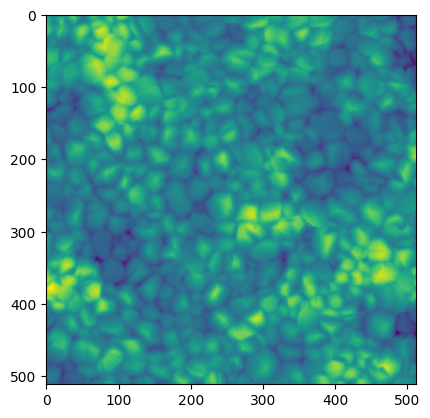

(512, 512)


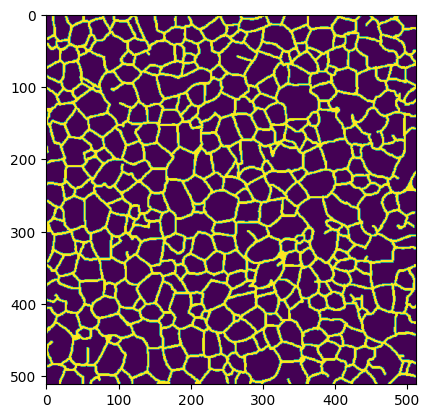

(512, 512)
[False  True]


In [9]:
index = np.random.randint(0, len(image_dataset)-1)
print(f'image dataset size: {len(image_dataset)}')
print(f'mask dataset size: {len(mask_dataset)}')

plt.imshow(image_dataset[index])
plt.show()
print(np.shape(image_dataset[index]))


plt.imshow(mask_dataset[index])
plt.show()
print(np.shape(mask_dataset[index]))
print(np.unique(mask_dataset[index]))

In [4]:
# Normalise the training images. The images are in 0-255 range with 3 channels
# 1600, 256, 256, 1
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1), 3)
# Do not normalize the masks, just rescale them to 0-1 range, because they do not have 3 colour channels.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3)

print(image_dataset.shape)
print(mask_dataset.shape)
print(np.unique(image_dataset))
print(f'min, max image dataset: {np.min(image_dataset), np.max(image_dataset)}')
print(np.unique(mask_dataset))

(112, 512, 512, 1)
(112, 512, 512, 1)
[0.01085833 0.01087139 0.01091471 ... 0.08278406 0.08293413 0.08344192]
min, max image dataset: (0.010858327981513208, 0.08344192462666888)
[False  True]


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.1, random_state=0)

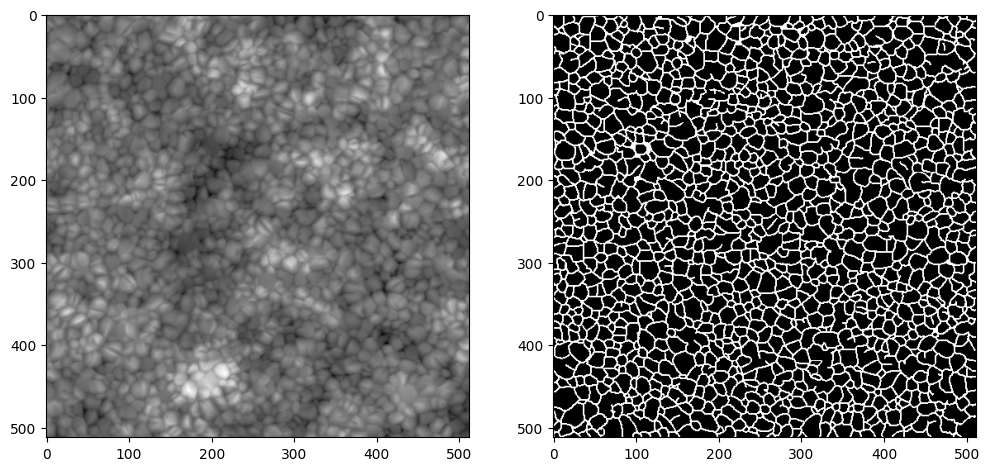

In [6]:
# Check things are working correctly
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (SIZE, SIZE)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (SIZE, SIZE)), cmap='gray')
plt.show()

In [7]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

2023-04-13 08:54:42.928167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-13 08:54:42.928811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
             

In [ ]:
# Can load the model:
# model.load_weights('mitochondria_test.hdf5')

In [14]:
history = model.fit(
    X_train,
    y_train,
    batch_size=4,
    verbose=1,
    epochs=50,
    validation_data=(X_test, y_test),
    shuffle=False
)

# DON'T FORGET TO SAVE IT IF NEEDED
model.save('_perovskite_512_b4_e50.hdf5')

Epoch 1/50
 3/25 [==>...........................] - ETA: 9s - loss: 0.2927 - accuracy: 0.8712 

KeyboardInterrupt: 

## Load model

In [6]:
# LOAD MODEL
import tensorflow as tf

model = tf.keras.models.load_model('./2023_04_11_perovskite_512_b4_e50.hdf5')
model.summary()


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-18 10:57:59.213100: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-18 10:57:59.213221: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [3]:
# Check model accuracy
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

NameError: name 'X_test' is not defined

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Valdation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [14]:
# Note that for semantic segmentation, accuracy is not the correct metric.

# Calculate IOU
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5 # this value is a probability cutoff

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print(f"IoU score: {iou_score}")

1/1 [==============================] - 0s 220ms/step


2023-04-13 08:58:45.893520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


IoU score: 0.5236408700121813


In [6]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
ground_truth = ground_truth.reshape(512, 512)
print(f'ground truth shape: {ground_truth.shape}')
test_img_norm=test_img[:, :, 0][:, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('Test image')
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.subplot(132)
plt.imshow(ground_truth, cmap='gray')
plt.title('Testing label')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')
plt.title('Prediction')
plt.show()

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(test_img)
ax.imshow(np.ma.masked_where(prediction == 0, prediction))
plt.show()

prediction = prediction == 0
print(f'prediction shape: {prediction.shape}')
difference = ground_truth.astype(int) - prediction.astype(int)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(difference)
ax.set_title('prediction difference')
plt.show()

labelled = label(prediction)
coloured = label2rgb(labelled)
plt.imshow(coloured)

NameError: name 'X_test' is not defined

In [13]:
# Flattening functions

def plane_tilt_removal(image: np.ndarray):
    read_matrix = image.copy()
    # Line of best fit
    # Calculate medians
    medians_x = [np.nanmedian(read_matrix[:, i]) for i in range(read_matrix.shape[1])]
    medians_y = [np.nanmedian(read_matrix[j, :]) for j in range(read_matrix.shape[0])]

    # Fit linear x
    px = np.polyfit(range(0, len(medians_x)), medians_x, 1)
    LOGGER.info(f"x-polyfit 1st order: {px}")
    py = np.polyfit(range(0, len(medians_y)), medians_y, 1)
    LOGGER.info(f"y-polyfit 1st order: {py}")

    if px[0] != 0:
        if not np.isnan(px[0]):
            LOGGER.info(f"Removing x plane tilt")
            for row in range(0, image.shape[0]):
                for col in range(0, image.shape[1]):
                    image[row, col] -= px[0] * (col)
        else:
            LOGGER.info(f"x gradient is nan, skipping plane tilt x removal")
    else:
        LOGGER.info("x gradient is zero, skipping plane tilt x removal")

    if py[0] != 0:
        if not np.isnan(py[0]):
            LOGGER.info(f"removing y plane tilt")
            for row in range(0, image.shape[0]):
                for col in range(0, image.shape[1]):
                    image[row, col] -= py[0] * (row)
        else:
            LOGGER.info("y gradient is nan, skipping plane tilt y removal")
    else:
        LOGGER.info("y gradient is zero, skipping plane tilt y removal")

    return image

def remove_polynomial(image: np.ndarray, mask: np.ndarray = None, order: int=2):
        image = image.copy()
        if mask is not None:
            read_matrix = np.ma.masked_array(image, mask=mask, fill_value=np.nan).filled()
        else:
            read_matrix = image

        # Calculate the median over the horizontal direction. (axis=0 since that's the dimension in which the median is taken for each
        # element of the median array)
        col_medians = np.nanmedian(read_matrix, axis=0) 

        # Fit the row median data to a polynomial
        coeffs = np.polyfit(range(0, read_matrix.shape[1]), col_medians, order)
        LOGGER.info(f"x polyfit nth order: {coeffs}")
        row_fit = np.polyval(coeffs, range(0, read_matrix.shape[1]))

        for row in range(0, read_matrix.shape[0]):
            image[row, :] -= row_fit

        return image

def zero_average(heightmap: np.ndarray) -> np.ndarray:
    median = np.nanmedian(heightmap)
    return np.subtract(heightmap, median)

def scale_heightmap(heightmap):
    heightmap = heightmap.astype(np.float32)
    min_value = heightmap.min()
    max_value = heightmap.max()
    heightmap = (heightmap - min_value) / (max_value - min_value)
    heightmap = heightmap * 255
    heightmap = heightmap.astype(np.uint8)
    return heightmap

def plot(img, title='', savepath=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img)
    ax.set_title(title)
    if savepath is not None:
        fig.savefig(savepath)
    plt.show()

def plot_with_means(img: np.ndarray, title: str=''):
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].imshow(img)
    ax[0].set_title('image')
    ax[1].plot(np.nanmedian(img, axis=0), '.')
    ax[1].set_title('axis: 0')
    ax[2].plot(np.nanmedian(img, axis=1), '.')
    ax[2].set_title('axis: 1')
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

original shape: 512.0
[Tue, 18 Apr 2023 11:29:08] [INFO    ] [topostats] Extracting image from perovskite_april/3cat_3um_1024.0_00002.spm
[Tue, 18 Apr 2023 11:29:08] [INFO    ] [topostats] Loading image from : perovskite_april/3cat_3um_1024.0_00002.spm
[Tue, 18 Apr 2023 11:29:08] [INFO    ] [topostats] [3cat_3um_1024.0_00002] : Loaded image from : perovskite_april/3cat_3um_1024.0_00002.spm
[Tue, 18 Apr 2023 11:29:08] [INFO    ] [topostats] [3cat_3um_1024.0_00002] : Extracted channel Height
[Tue, 18 Apr 2023 11:29:08] [INFO    ] [topostats] [3cat_3um_1024.0_00002] : Pixel to nm scaling : 2.9296875
[Tue, 18 Apr 2023 11:29:08] [INFO    ] [topostats] Loading image from : perovskite_april/3cat_3um_1024.0_00002.spm
[Tue, 18 Apr 2023 11:29:08] [INFO    ] [topostats] [3cat_3um_1024.0_00002] : Loaded image from : perovskite_april/3cat_3um_1024.0_00002.spm
[Tue, 18 Apr 2023 11:29:08] [INFO    ] [topostats] [3cat_3um_1024.0_00002] : Extracted channel Height
[Tue, 18 Apr 2023 11:29:08] [INFO    ] 

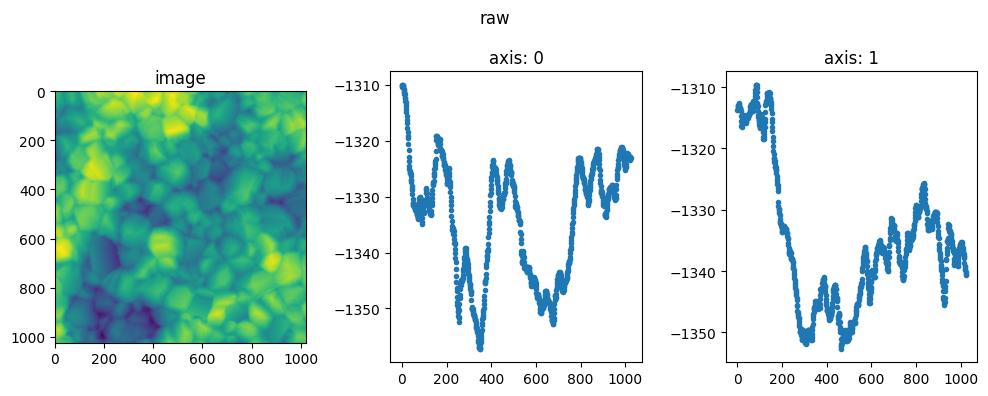

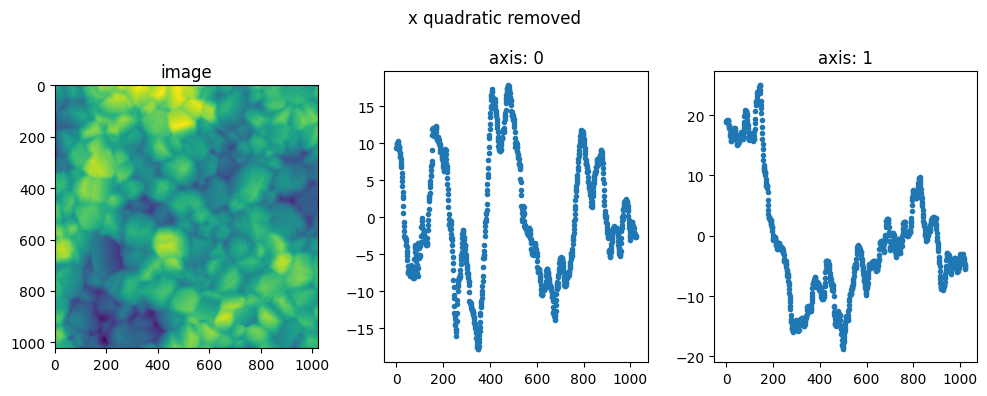

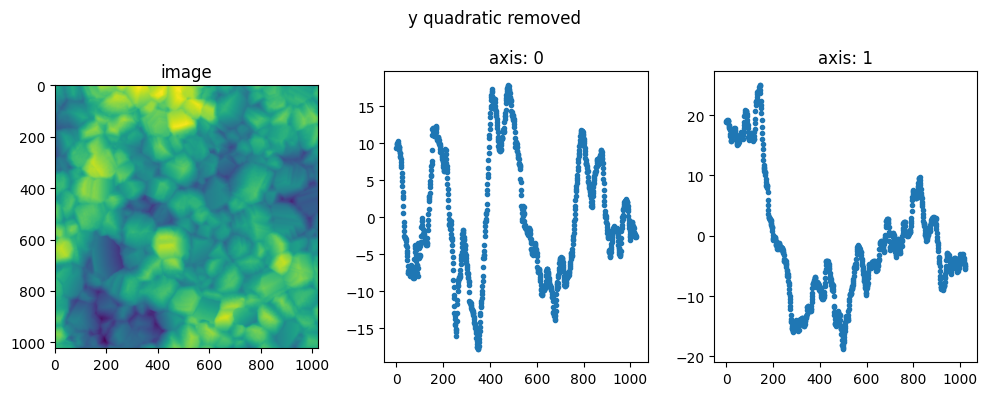

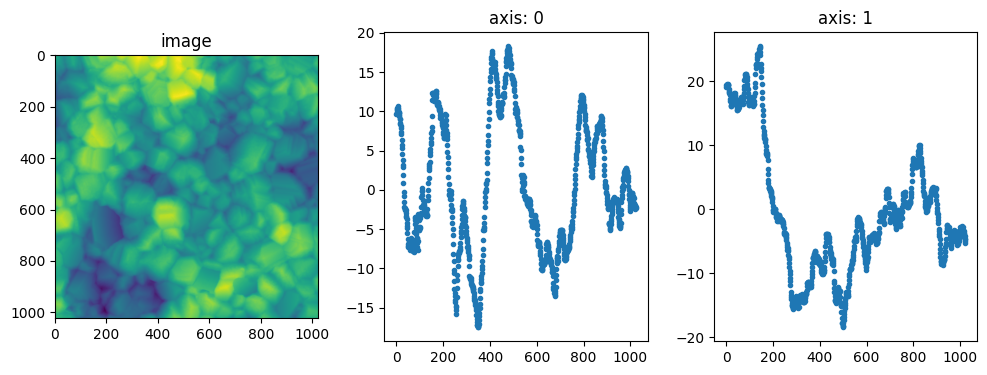

min: -106.86243437740211 max: 81.35248269373812
min: 0.05232321436149445 max: 0.05232321436149445
(1024, 1024)
min, max values: (0.0, 0.05232321436149445)
(512, 512)
to predict shape: (1, 512, 512)
to predict shape: (1, 512, 512, 1)
(1, 512, 512, 1)
1/1 [==============================] - 0s 19ms/step
[0 1]
[False  True]


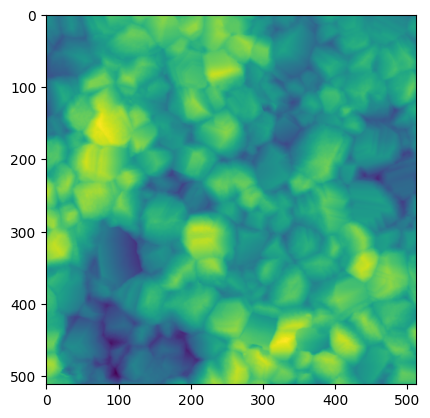

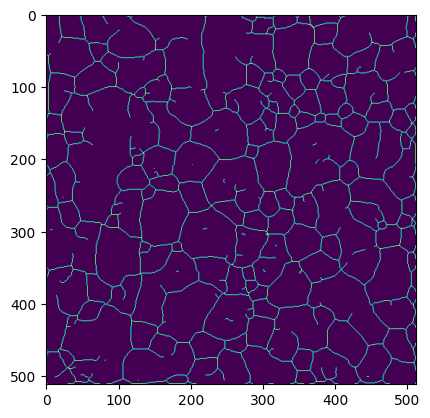

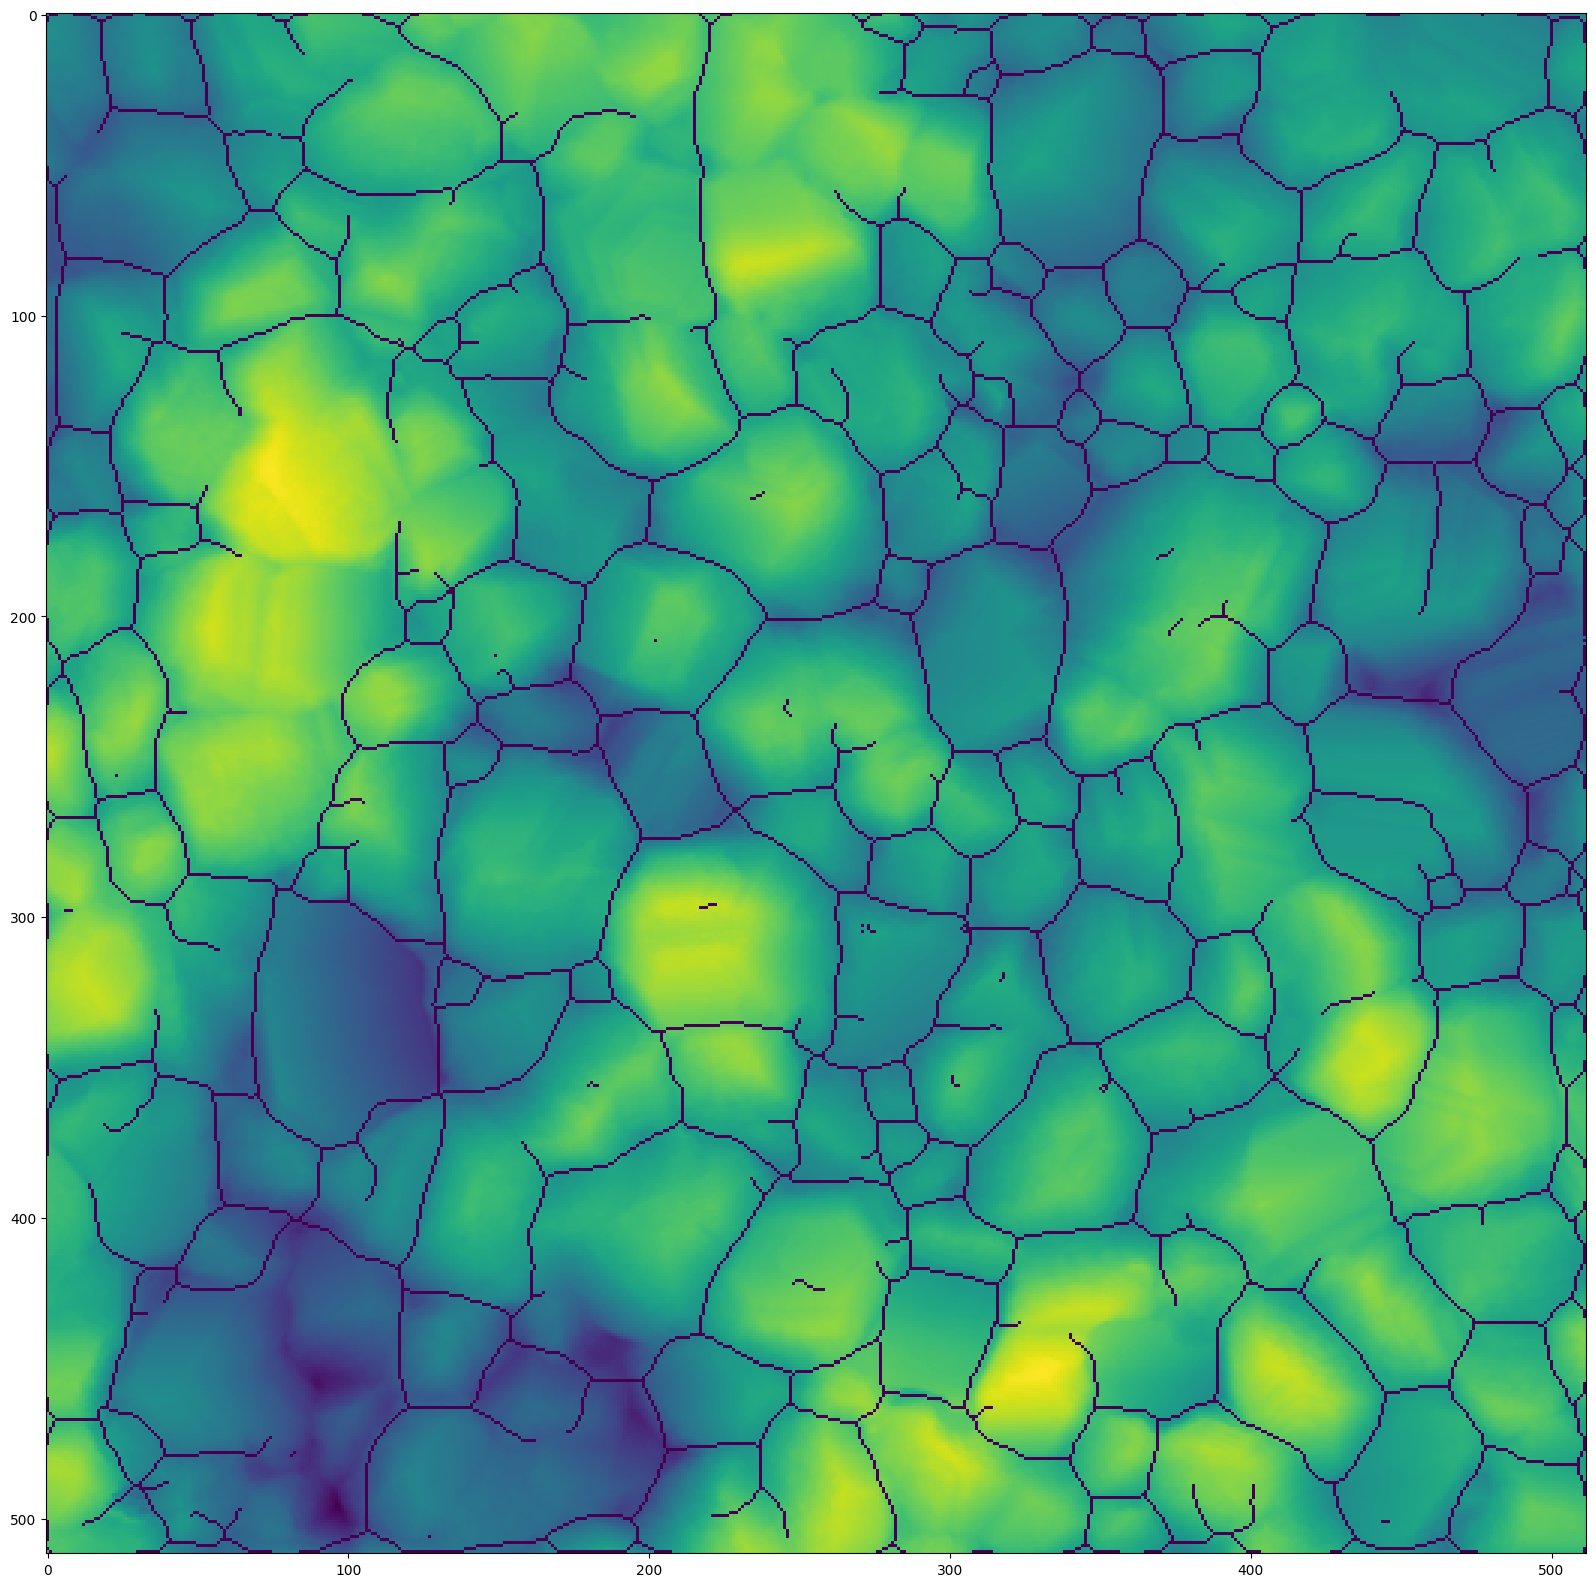

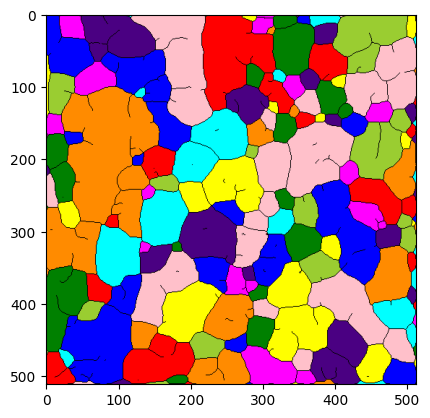

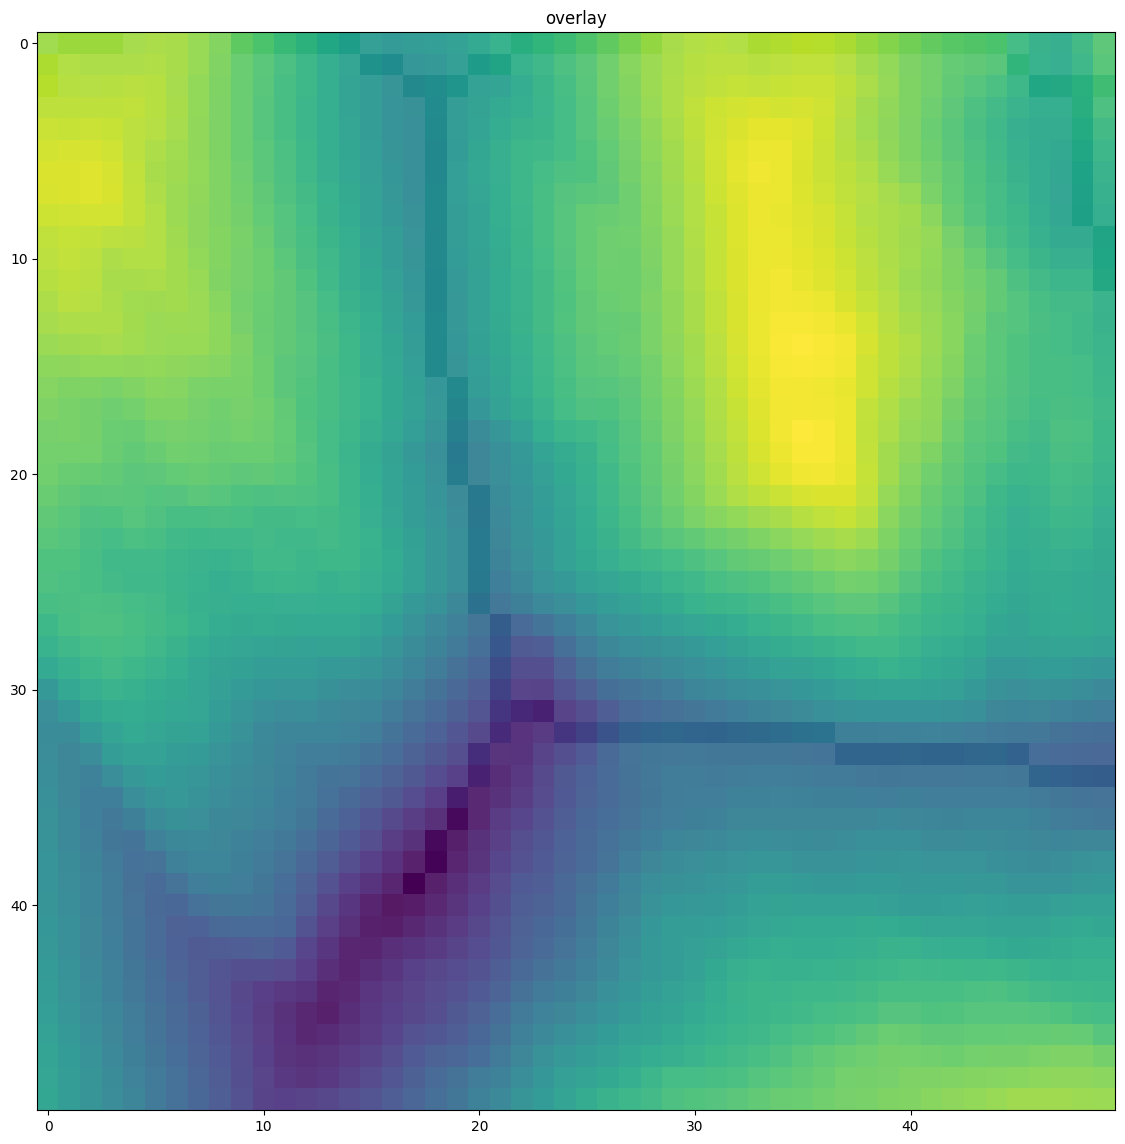

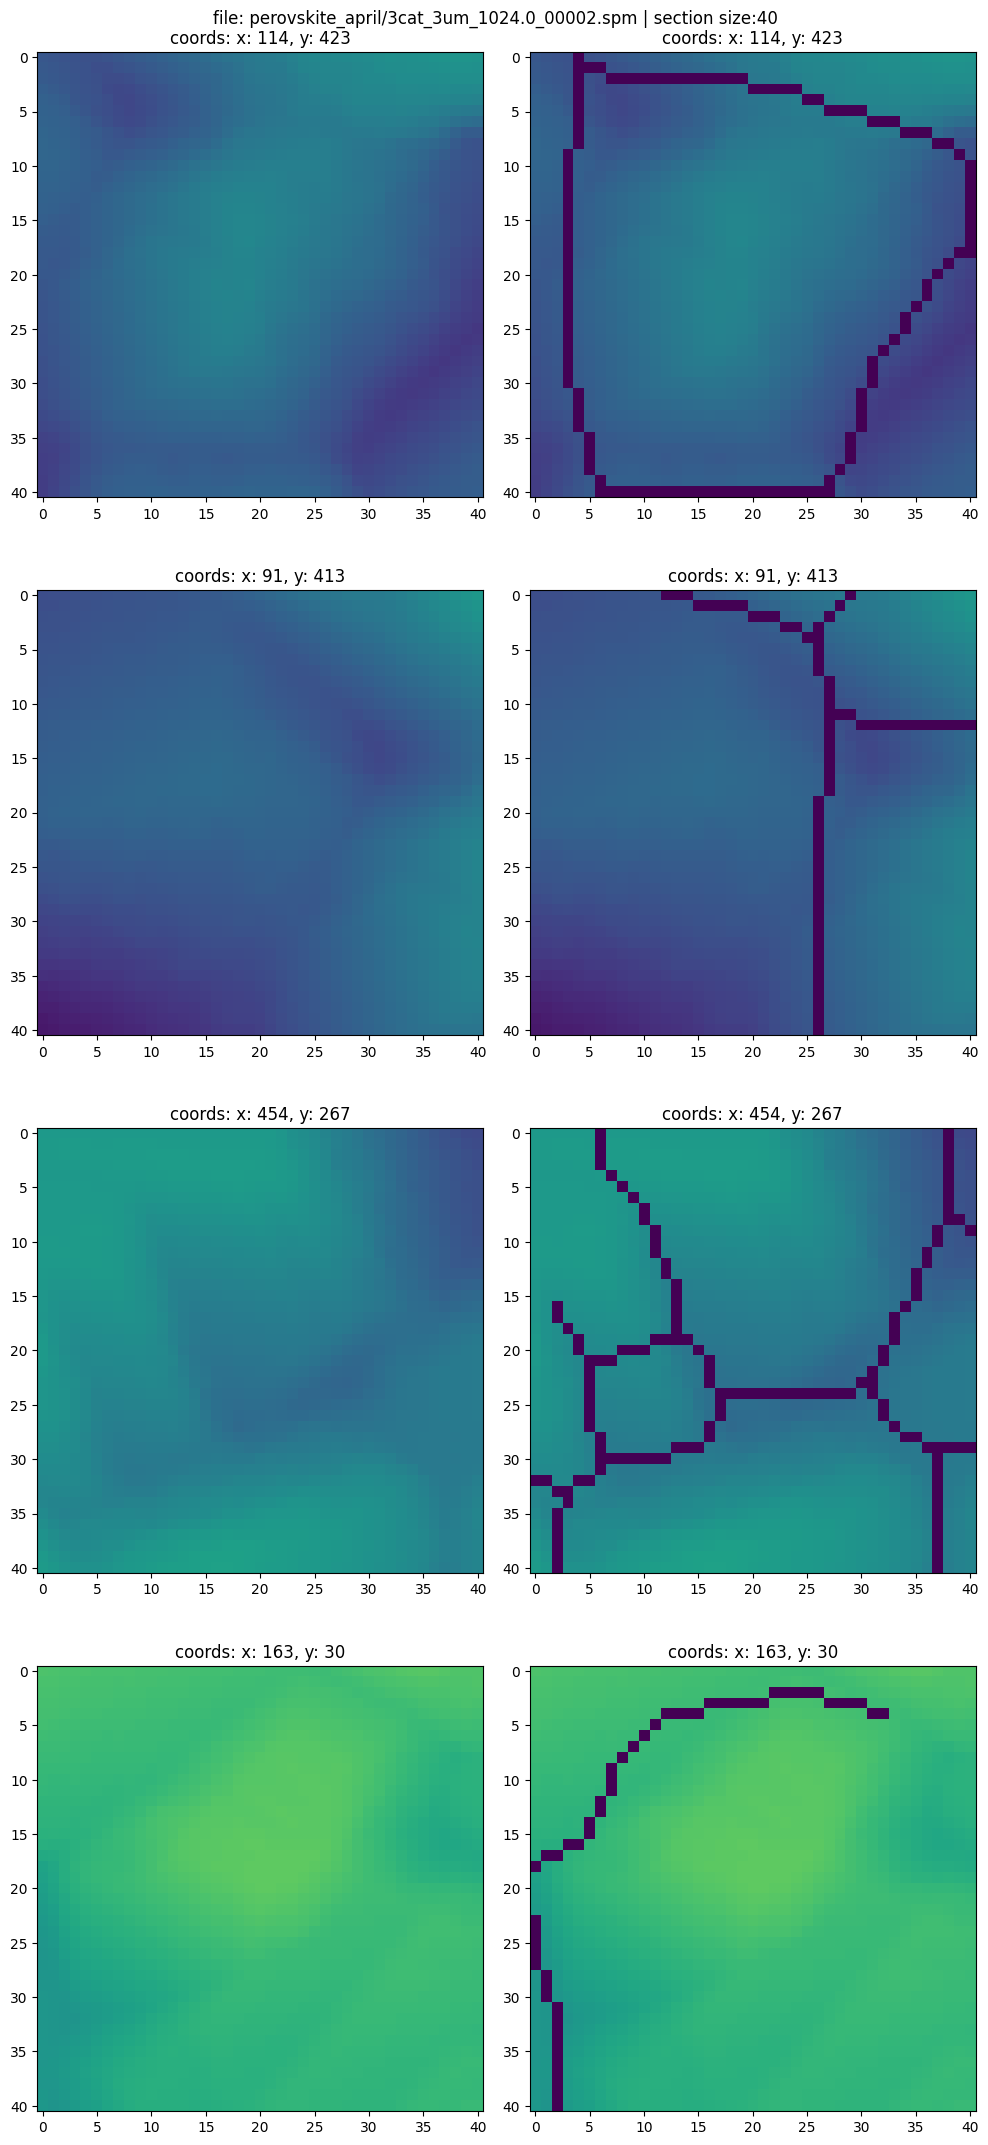

In [19]:
# Try another image
# FROM PNG
another_image_file = './dl_data/to_be_labelled/20230207_MeO_perov_10um.0_00001.png'
image = cv2.imread(another_image_file, 0)
print(f'original shape: {np.sqrt(image.size)}')
# FROM SPM
another_image_file = Path('./perovskite_april/3cat_3um_1024.0_00002.spm')
from topostats import io
# loadscan = io.LoadScans(img_paths = [file], channel='ZSensorRetrace')
loadscan = io.LoadScans(img_paths = [another_image_file], channel='Height')
loadscan.get_data()
# data, pixel_to_nm = loadscan.load_ibw()
image, pixel_to_nm = loadscan.load_spm()

plot_with_means(image, title='raw')
image = remove_polynomial(image, order=3)
plot_with_means(image, title='x quadratic removed')
img = remove_polynomial(image.T, order=3).T
plot_with_means(image, title='y quadratic removed')
image = zero_average(image)
plot_with_means(image)

print(f'min: {np.min(image)} max: {np.max(image)}')
image = image - np.min(image)
image = normalize(image)
print(f'min: {np.max(image)} max: {np.max(image)}')

print(image.shape)
print(f'min, max values: {np.min(image), np.max(image)}')
image =  Image.fromarray(image)
image = image.resize((SIZE, SIZE))
image = np.array(image)
print(image.shape)

to_predict = []
to_predict.append(image)

to_predict = np.array(to_predict)
print(f'to predict shape: {to_predict.shape}')
to_predict = np.expand_dims(normalize(to_predict), 3)
print(f'to predict shape: {to_predict.shape}')

test_img = to_predict[0]
test_img = test_img[:, :, 0][:, :, None]
test_img = np.expand_dims(test_img, 0)
print(test_img.shape)

prediction = (model.predict(test_img)[0, :, :, 0] > 0.05).astype(np.uint8)
print(np.unique(prediction))
prediction = skeletonize(prediction)
print(np.unique(prediction))
plt.imshow(image)
plt.show()
plt.imshow(prediction)
plt.show()

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(image)
masked = np.ma.masked_where(prediction.astype(int) == 0, prediction)
ax.imshow(masked)
plt.show()

labelled = label(prediction == 0, connectivity=1)
coloured = label2rgb(labelled)
fig, ax = plt.subplots()
ax.imshow(coloured)
plt.show()

fig, ax = plt.subplots(figsize=(14, 14))
test_mask = np.zeros(image.shape)
for j in range(coloured.shape[0]):
    for i in range(coloured.shape[1]):
        if np.array_equal(coloured[j, i], np.array([0, 0, 0])):
            test_mask[j, i] = 1


overlay = np.zeros(image.shape)

test_masked = np.ma.masked_where(test_mask == 1, overlay)
ax.imshow(image[0:50, 0:50])
ax.imshow(test_masked[0:50, 0:50], alpha=0.1, cmap='binary')
ax.set_title('overlay')


fig, ax = plt.subplots(4, 2, figsize=(10, 22))
section_size = 40
vmin = np.min(image)
vmax = np.max(image)
for index in range(ax.shape[0]):
    y = np.random.randint(0, image.shape[0]-section_size)
    x = np.random.randint(0, image.shape[1]-section_size)
    img_section = image[y:y+section_size+1, x:x+section_size+1]
    mask_section = masked[y:y+section_size+1, x:x+section_size+1]
    ax[index, 0].imshow(img_section, vmin=vmin, vmax=vmax)
    ax[index, 1].imshow(img_section, vmin=vmin, vmax=vmax)
    ax[index, 1].imshow(mask_section)
    ax[index, 0].set_title(f'coords: x: {x}, y: {y}')
    ax[index, 1].set_title(f'coords: x: {x}, y: {y}')
fig.suptitle(f'file: {another_image_file} | section size:{section_size}')
fig.tight_layout()


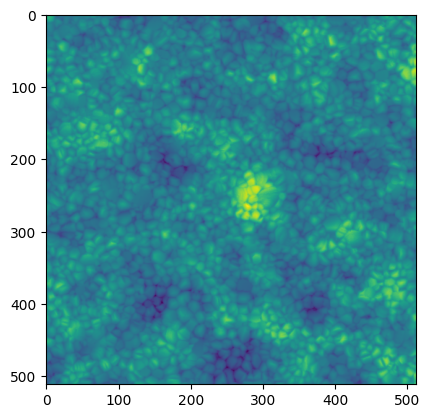

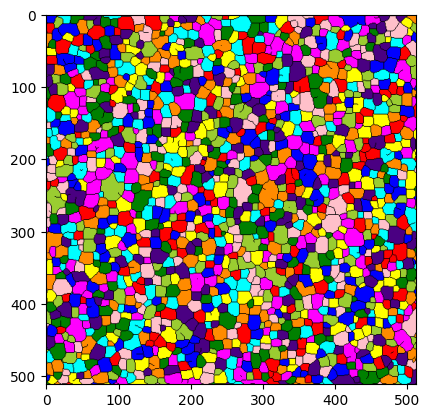

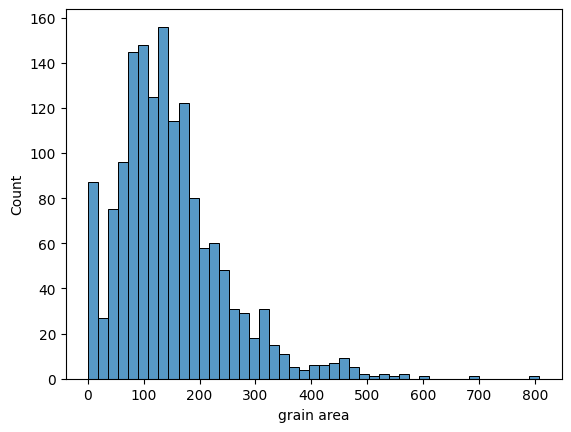

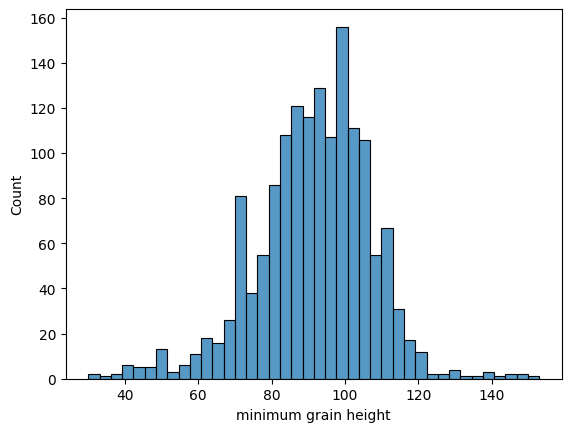

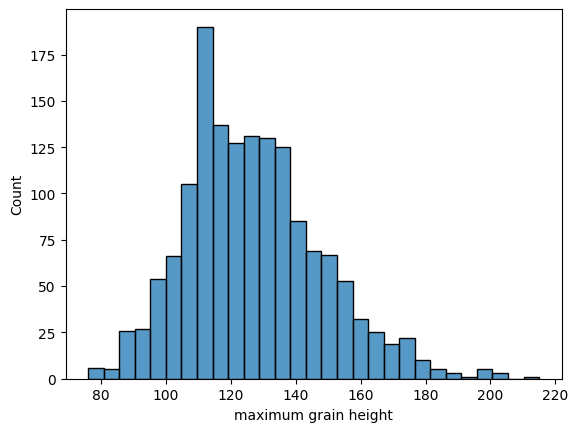

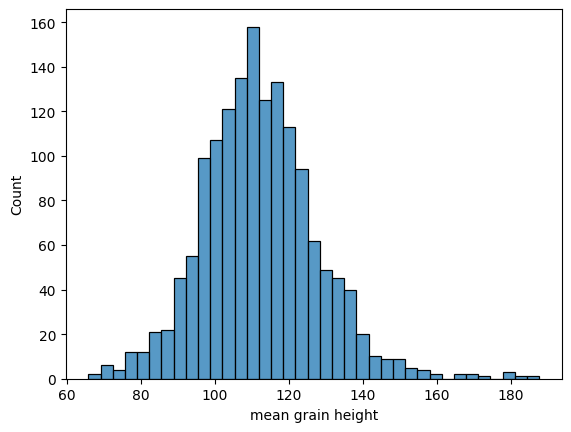

mean grain area: 149.1726618705036
mean mean grain height: 112.0923961836612
number of grains: 1529


In [156]:
# Grain stats

areas = []
mean_heights = []
max_heights = []
min_heights = []

region_props = regionprops(labelled)
for index, props in enumerate(region_props):
    if props.label == 0:
        pass
    else:
        areas.append(props.area)
        heights = image[labelled == props.label]
        mean_heights.append(np.mean(heights))
        min_heights.append(np.min(heights))
        max_heights.append(np.max(heights))

plt.imshow(image)
plt.show()
plt.imshow(coloured)
plt.show()

ax = sns.histplot(areas)
ax.set_xlabel('grain area')
plt.show()

ax = sns.histplot(min_heights)
ax.set_xlabel('minimum grain height')
plt.show()

ax = sns.histplot(max_heights)
ax.set_xlabel('maximum grain height')
plt.show()

ax = sns.histplot(mean_heights)
ax.set_xlabel('mean grain height')
plt.show()

print(f'mean grain area: {np.mean(areas)}')
print(f'mean mean grain height: {np.mean(mean_heights)}')
print(f'number of grains: {len(areas)}')